# Classification model

In [ ]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('pnd_data.csv')

In [ ]:
#make one hot vector for coin and channel
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
#columns = ['channel', 'currency', 'exchange']
def one_hot(col):
    col = df[col]
    col = preprocessing.LabelEncoder().fit_transform(col).reshape(-1,1)
    col = OneHotEncoder().fit_transform(col).toarray()
    return col
channel = one_hot('channel')
currency = one_hot('currency')
channel_currency = np.concatenate([channel,currency], axis = 1)

In [6]:
#number of channel
print(channel.shape)
#number of coins
print(currency.shape)

(535, 98)
(535, 216)


In [7]:
X = np.concatenate([df[['month','hour_cos','hour_sin','subscriber_0901','exchange','ranked']].values, channel_currency], axis =1)
Y = df['success'].values
X.shape

(535, 320)

In [ ]:
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
#split the data into train data (80%) and test data (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
class Model():
    def __init__(self, model, X_train = X_train, Y_train = Y_train):
        self.model = model
        self.xtrain = X_train
        self.ytrain = Y_train
    
    def train(self, params):
        self.params = params
        self.grid_search = GridSearchCV(self.model, self.params, cv=StratifiedKFold(n_splits=5, random_state=1).split(self.xtrain, self.ytrain), 
                           verbose=1, n_jobs=1) 
        self.clf = self.grid_search.fit(self.xtrain, self.ytrain)
        print(self.clf.best_params_)
  
    def predict(self, X_test = X_test, Y_test = Y_test):
        self.xtest = X_test
        self.ytest = Y_test
        self.predict = self.clf.predict(self.xtest)
        print(classification_report(self.ytest, self.predict))

    def make_matrix(self):
        matrix = confusion_matrix(self.ytest, self.predict)[::-1][:, ::-1]
        proportions = np.zeros((2,2))
        for i in range(0,2):
            proportions[i,:] = matrix[i,:]/float(matrix[i,:].sum())
        names=['successful','unsuccessful']
        confusion_df = pd.DataFrame(proportions, index=names,columns=names)
        plt.figure(figsize=(5,5))
        seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 14},cmap='Blues',square=True,fmt='.2f')
        plt.title("confusion matrix (%)", fontsize=20)
        plt.xlabel('Prediction',fontsize=16)
        plt.ylabel('True',fontsize=16)
        plt.tick_params(labelsize=12)

    def predict_unknown(self, test):
        self.test = test
        self.predict_unknown  = self.clf.predict(self.test)
        return self.predict_unknown


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   19.0s finished


{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 25}
              precision    recall  f1-score   support

           0       0.74      0.75      0.75        53
           1       0.75      0.74      0.75        54

    accuracy                           0.75       107
   macro avg       0.75      0.75      0.75       107
weighted avg       0.75      0.75      0.75       107



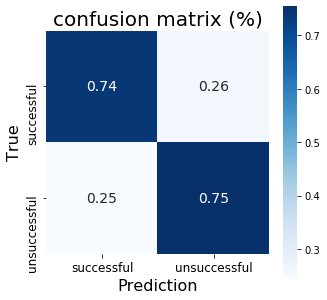

In [11]:
rf = Model(RandomForestClassifier(class_weight ='balanced', random_state = 1))
rf_params ={
    'criterion': ['gini', 'entropy'],
    'max_depth':  [10, 15, 20, None],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [5,10,15,20,25]}
rf.train(rf_params)
rf.predict()
rf.make_matrix()

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.9min finished


{'xg__colsample_bytree': 0.5, 'xg__learning_rate': 0.1, 'xg__max_depth': 2, 'xg__subsample': 0.5}
              precision    recall  f1-score   support

           0       0.67      0.77      0.72        53
           1       0.74      0.63      0.68        54

    accuracy                           0.70       107
   macro avg       0.71      0.70      0.70       107
weighted avg       0.71      0.70      0.70       107



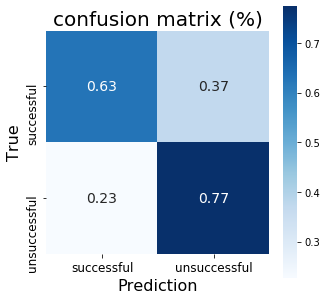

In [12]:
import xgboost as xgb
xg = Model(xgb.XGBClassifier(class_weight = 'balanced', random_state = 1))
xg_params = {"xg__learning_rate":[0.1,0.3,0.5],
        "xg__max_depth": [2,3,5,10],
         "xg__subsample":[0.5,0.8,0.9,1],
         "xg__colsample_bytree": [0.5,1.0],
         }
xg.train(xg_params)
xg.predict()
xg.make_matrix()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    4.3s finished


{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
              precision    recall  f1-score   support

           0       0.71      0.75      0.73        53
           1       0.75      0.70      0.72        54

    accuracy                           0.73       107
   macro avg       0.73      0.73      0.73       107
weighted avg       0.73      0.73      0.73       107



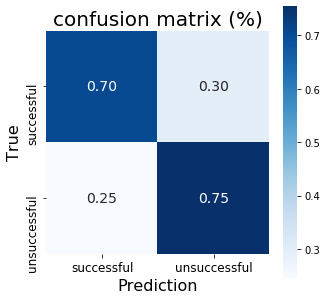

In [13]:
import lightgbm as lgb
lg = Model(lgb.LGBMClassifier(class_weight = 'balanced', random_state =1))
lg_params = {"learning_rate":[0.1,0.3,0.5],
        "max_depth": [2,3,5,10],
         "subsample":[0.5,0.8,0.9,1],
         }
lg.train(lg_params)
lg.predict()
lg.make_matrix()

## see the manifold

In [14]:
Y2 =np.reshape(Y, (Y.shape[0],1))
x_y  = np.concatenate((X, Y2), axis =1)
#get feature vectors for successful and unsuccessful pumps
successful = x_y[x_y[:, x_y.shape[1]-1] ==1]
unsuccessful = x_y[x_y[:, x_y.shape[1]-1] ==0]
print(successful.shape)
print(unsuccessful.shape)
#take out answers (label)
successful = successful[:, :successful.shape[1]-1]
unsuccessful = unsuccessful[:, :unsuccessful.shape[1]-1]

print(successful.shape)
print(unsuccessful.shape)
manifold = np.concatenate([successful, unsuccessful])
print(manifold.shape)

(280, 321)
(255, 321)
(280, 320)
(255, 320)
(535, 320)


### project into $\mathbb{R^{2}}$, see the manifold

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
embeds = TSNE(n_components=2, random_state =0).fit_transform(manifold)
es, eu = embeds[:len(successful)], embeds[len(successful):]

In [17]:
print(embeds[:,0].shape)
print(embeds[:,1].shape)

(535,)
(535,)


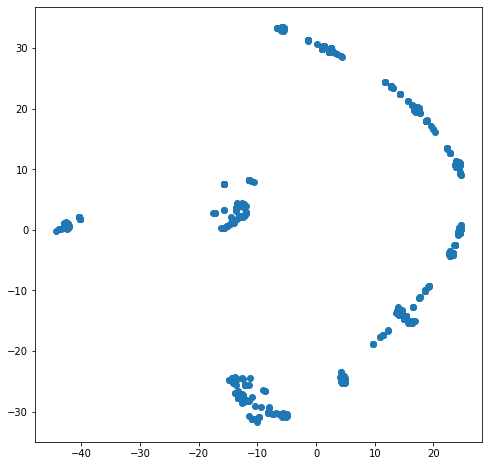

In [18]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(embeds[:,0],embeds[:,1])

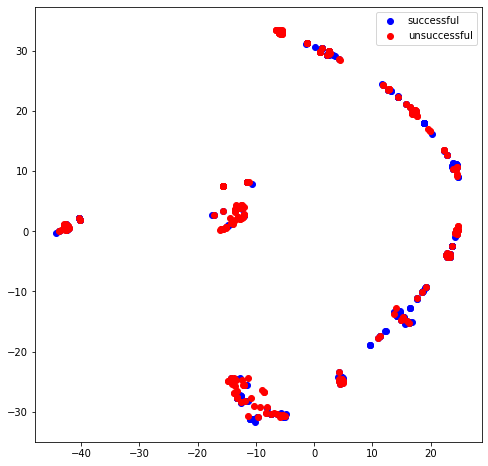

In [19]:

plt.rcParams["figure.figsize"] = (8, 8)

plt.scatter([x for x, y in es], [y for x, y in es], color='blue')
plt.scatter([x for x, y in eu], [y for x, y in eu], color='red')

plt.legend(['successful', 'unsuccessful'])